In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
from matplotlib.patches import Rectangle
import struct
import imageio
import collections
import pickle
import re
import requests
import pandas as pd
from pathlib import Path
import pretty_errors
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
from filter_BU import filt_B
import my_pyrotd
from awp_processing import awp
from post_processing.la_habra import *

np.errstate(divide='ignore')
#%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
rcparams = {'font.size': 16,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'lines.linewidth': 1.5,
            'figure.dpi': 300}
mpl.rcParams.update(rcparams)

mpl.style.use('seaborn')
import seaborn as sns; 
sns.set(context='paper', style='whitegrid', font_scale=1, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({'legend_frameon':False})

<Figure size 432x288 with 0 Axes>

In [4]:
def SH1D(vs, h, f, theta=0):
    """
    vs: 1D array (N) listing vs in each layer, beginning with the uppermost
    h: 1D array (N-1) of thickness of each layer
    f: frequency range
    """
    qs = estimateQfromVs(vs)
    ro = estimateRhofromVs(vs)
    # theta = 0       # incidence angle in half space (lowest)
    N = len(vs)
    ga = np.ones(N) - 0.5j * np.ones(N) / qs
    p = np.sin(theta * pi / 180) / vs[-1]
    eta = ((np.ones(N - 1) / (vs[:-1] * ga[:-1]) ** 2) - p ** 2 * np.ones(N - 1)) ** 0.5
    Im = ro * vs * ga
    r = (Im[1:] - Im[0:-1]) / (Im[1:] + Im[0:-1])
    t = 2 * Im[1:] / (Im[0:-1] + Im[1:])
    tau = eta * h
    factor = 1
    S11 = 1
    S22 = 1
    S12 = 0
    S21 = 0
    for k in range(N - 1):
        factor = factor * t[k]
        A11 = exp(-1j * 2 * pi * tau[k] * f)
        A12 = r[k] * exp(1j * 2 * pi * tau[k] * f)
        A21 = r[k] * exp(-1j * 2 * pi * tau[k] * f)
        A22 = exp(1j * 2 * pi * tau[k] * f)
        Stmp11 = A11 * S11 + A12 * S21
        Stmp21 = A21 * S11 + A22 * S21
        Stmp12 = A11 * S12 + A12 * S22
        Stmp22 = A21 * S12 + A22 * S22
        S11 = Stmp11
        S12 = Stmp12
        S21 = Stmp21
        S22 = Stmp22
    amp = np.abs(factor * np.ones(len(f)) / (S11 + S12))
    return amp

In [8]:
vs = np.fromfile('ssh_GVDA/mesh_gvda_4m.bin', 'f').reshape(100, 1000, 1000, 5)[:,:,:,1]
print(np.min(vs))

220.0


In [9]:
def fetch_TKCH05(depth):
    if depth <= 6:
        return 140
    elif depth <= 18:
        return 430
    elif depth <= 30:
        return 660
    elif depth <= 80:
        return 770
    elif depth <= 98:
        return 640
    elif depth <= 295:
        return 1100
    
def fetch_HKD090(depth):
    if depth <= 2:
        return 137
    elif depth <= 5:
        return 97
    else:
        return 855
    
def plot_discret_curve(depths, vs=[0] * 1000):
    
    v_HKD090 = list(map(fetch_HKD090, np.arange(0, 15)))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=600)
    for depth in depths:
        v_TKCH05 = list(map(fetch_TKCH05, depth))
        inc = depth[1] - depth[0]
        ax.plot(v_TKCH05, depth, ls='-', label=f'TKCH05')
    ax.plot(v_HKD090, np.arange(0, 15), ls='-', label='HKD090')
    ax.plot(vs[:48], np.arange(48) * 2.5, ls='-.', label='Simplified')
    ax.set_xlabel('Vs (m/s)')
    ax.set_ylabel('Depth (m)')
    ax.legend(loc=3)
    ax.invert_yaxis()
    return fig

In [ ]:
vs = np.fromfile('/ccs/home/hzfmer/scratch/preevents/ssh/mesh_TKCH05_052119_2v680_bd98.bin', dtype='float32').reshape(400, 400, 400, 5)
vs = vs[:, 200, 200, 1]
print(vs)
vs[40] = 1100
fig = plot_discret_curve([np.arange(0, 120, d) for d in [2.5]])
print(vs[41])
fig.savefig(f"/ccs/home/hzfmer/scratch/preevents/ssh/TKCH05_HKD090_vs_profile.png", dpi=600, bbox_inches='tight', pad_inches=0.05)

[ 140.  140.  140.  680.  680.  680.  680.  680.  680.  680.  680.  680.
  680.  680.  680.  680.  680.  680.  680.  680.  680.  680.  680.  680.
  680.  680.  680.  680.  680.  680.  680.  680.  680.  680.  680.  680.
  680.  680.  680.  680. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100.
 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100.
 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100.
 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100.
 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100.
 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100.
 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1100. 1400. 1400.
 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400.
 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400.
 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400.
 1400. 1400. 1400. 1400. 1400. 1400. 1400. 1400. 14

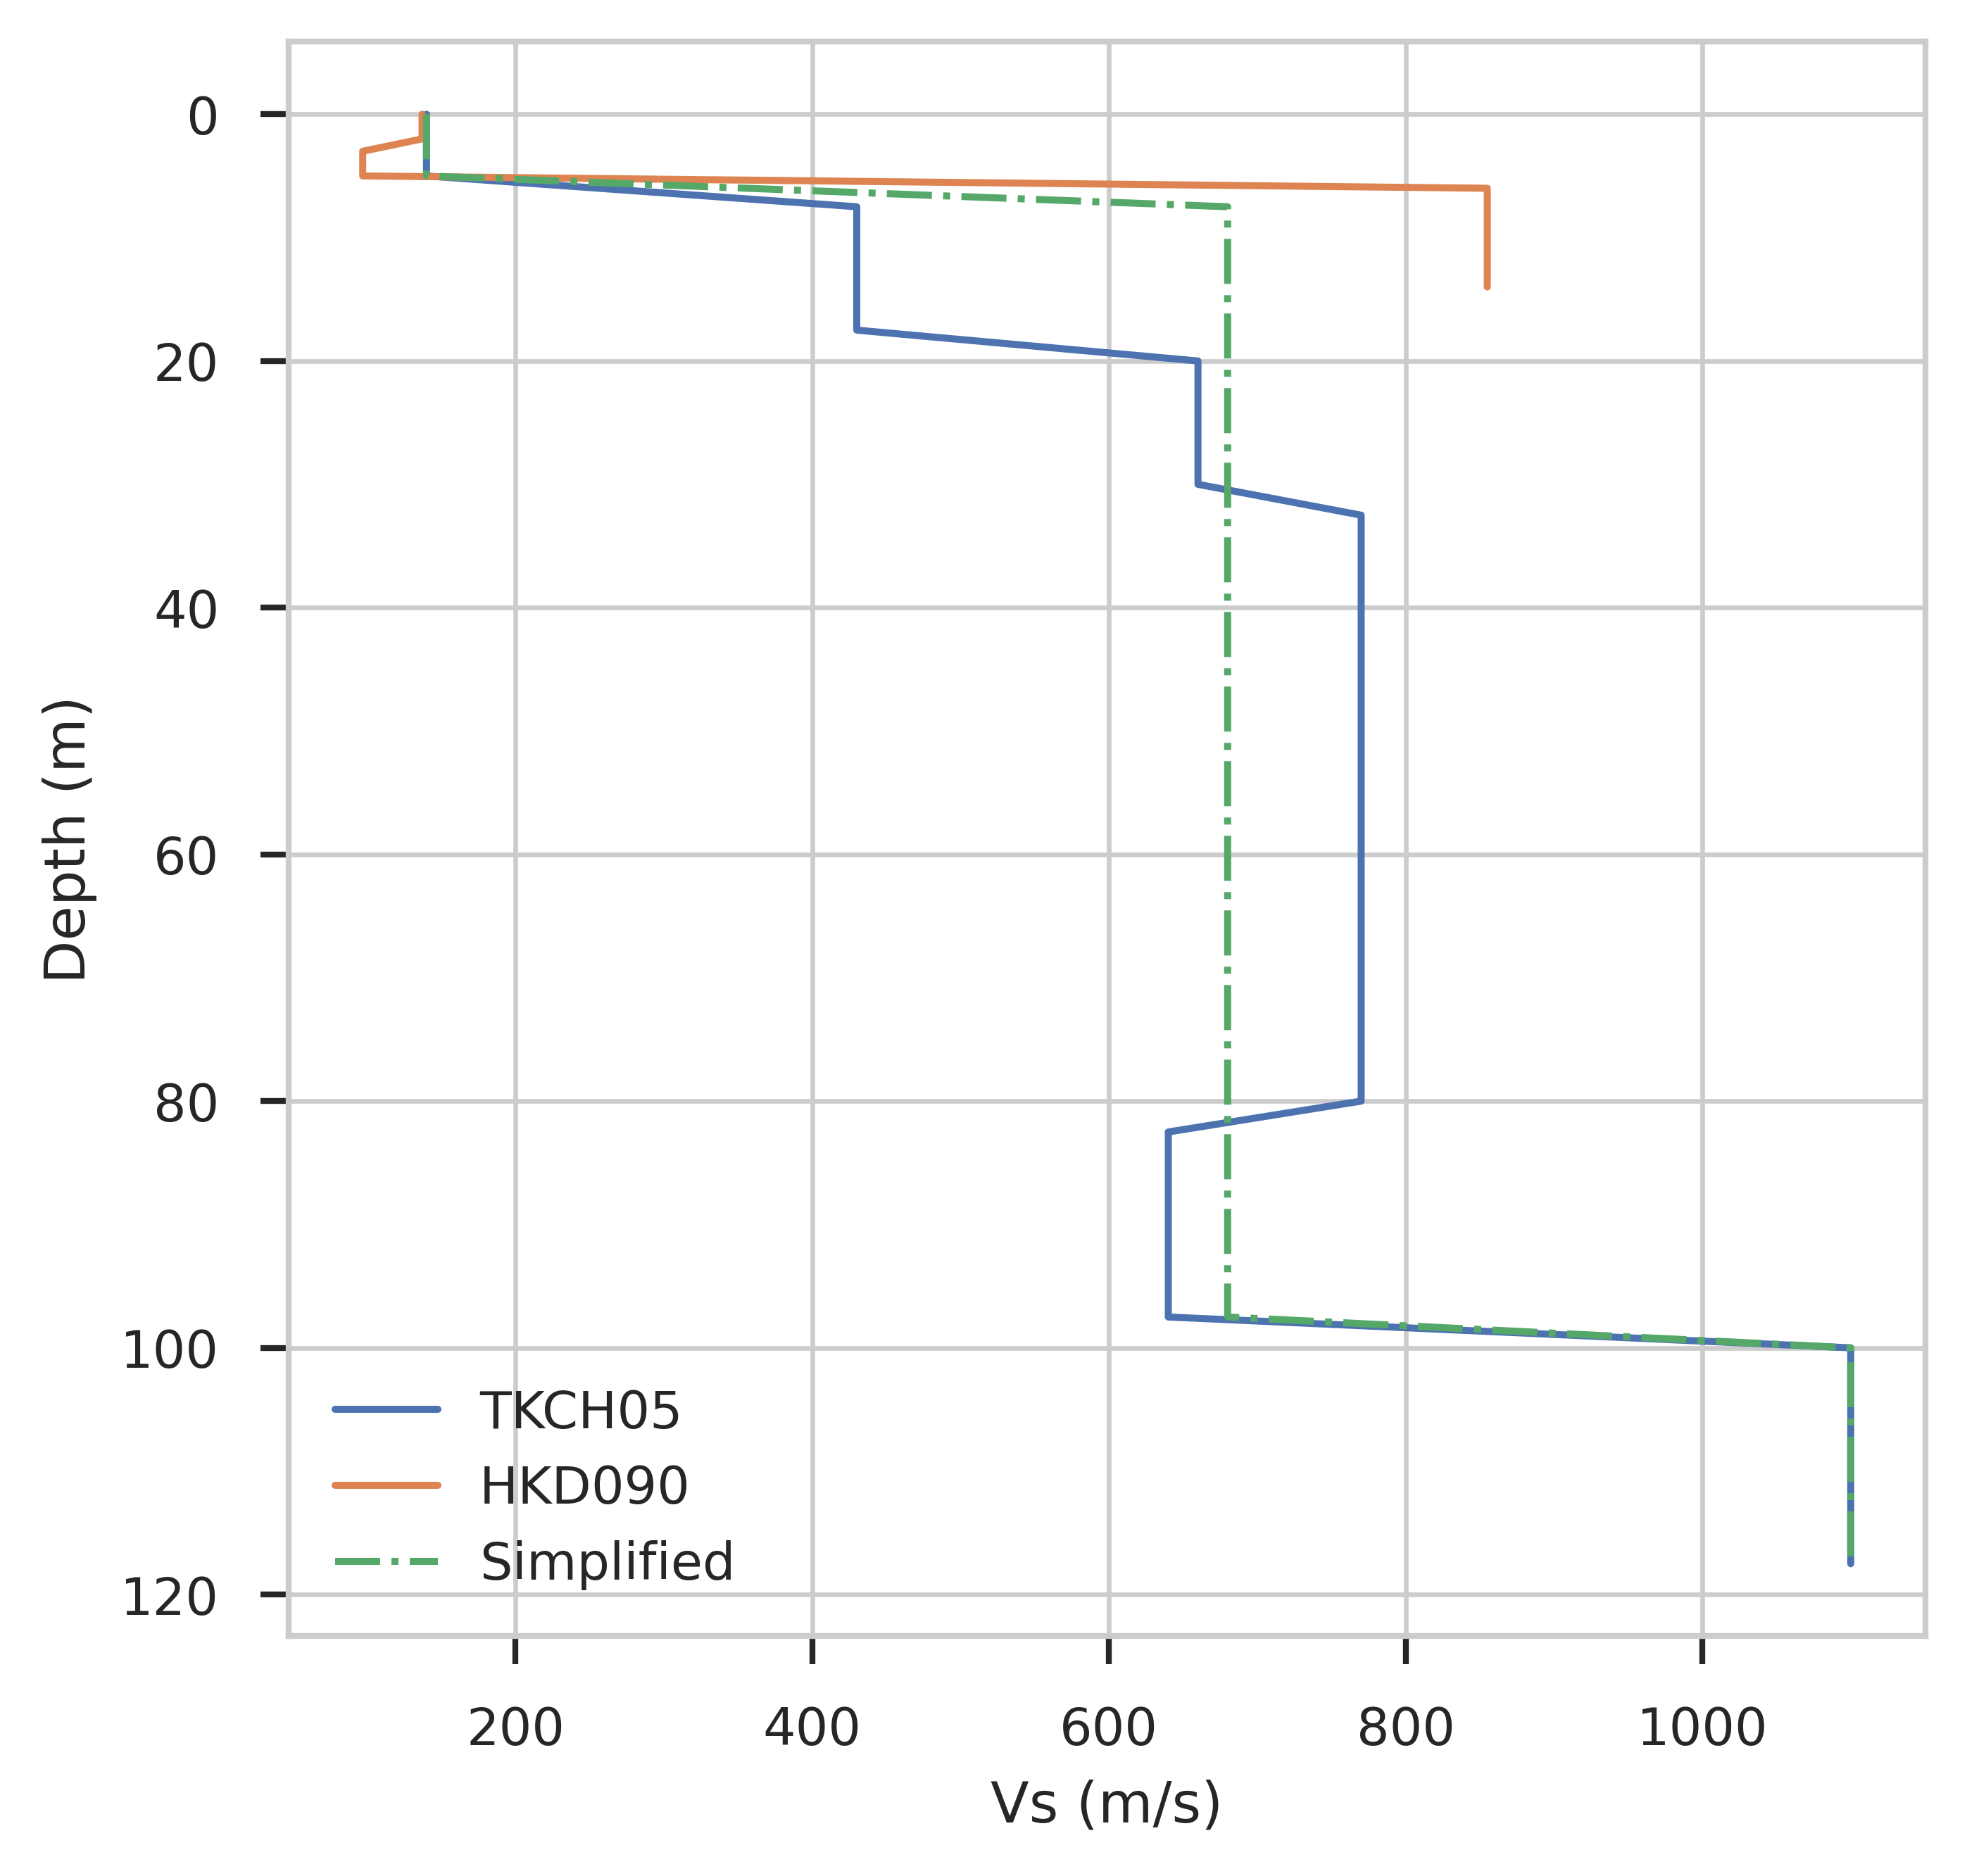

In [13]:
vs = np.fromfile('/ccs/home/hzfmer/scratch/preevents/ssh/mesh_TKCH05_1d_simp_050520.bin', dtype='float32').reshape(400, 64, 64, 5)
vs = vs[:, 32, 33, 1]
print(vs)
#vs[40] = 1100
fig = plot_discret_curve([np.arange(0, 120, d) for d in [2.5]], vs=vs)
print(vs[41])
#fig.savefig(f"/ccs/home/hzfmer/scratch/preevents/ssh/TKCH05_HKD090_vs_profile.png", dpi=600, bbox_inches='tight', pad_inches=0.05)

Minimum Vs including first layer: 200.000 m/s
Minimum Vs excluding first layer: 200.000 m/s


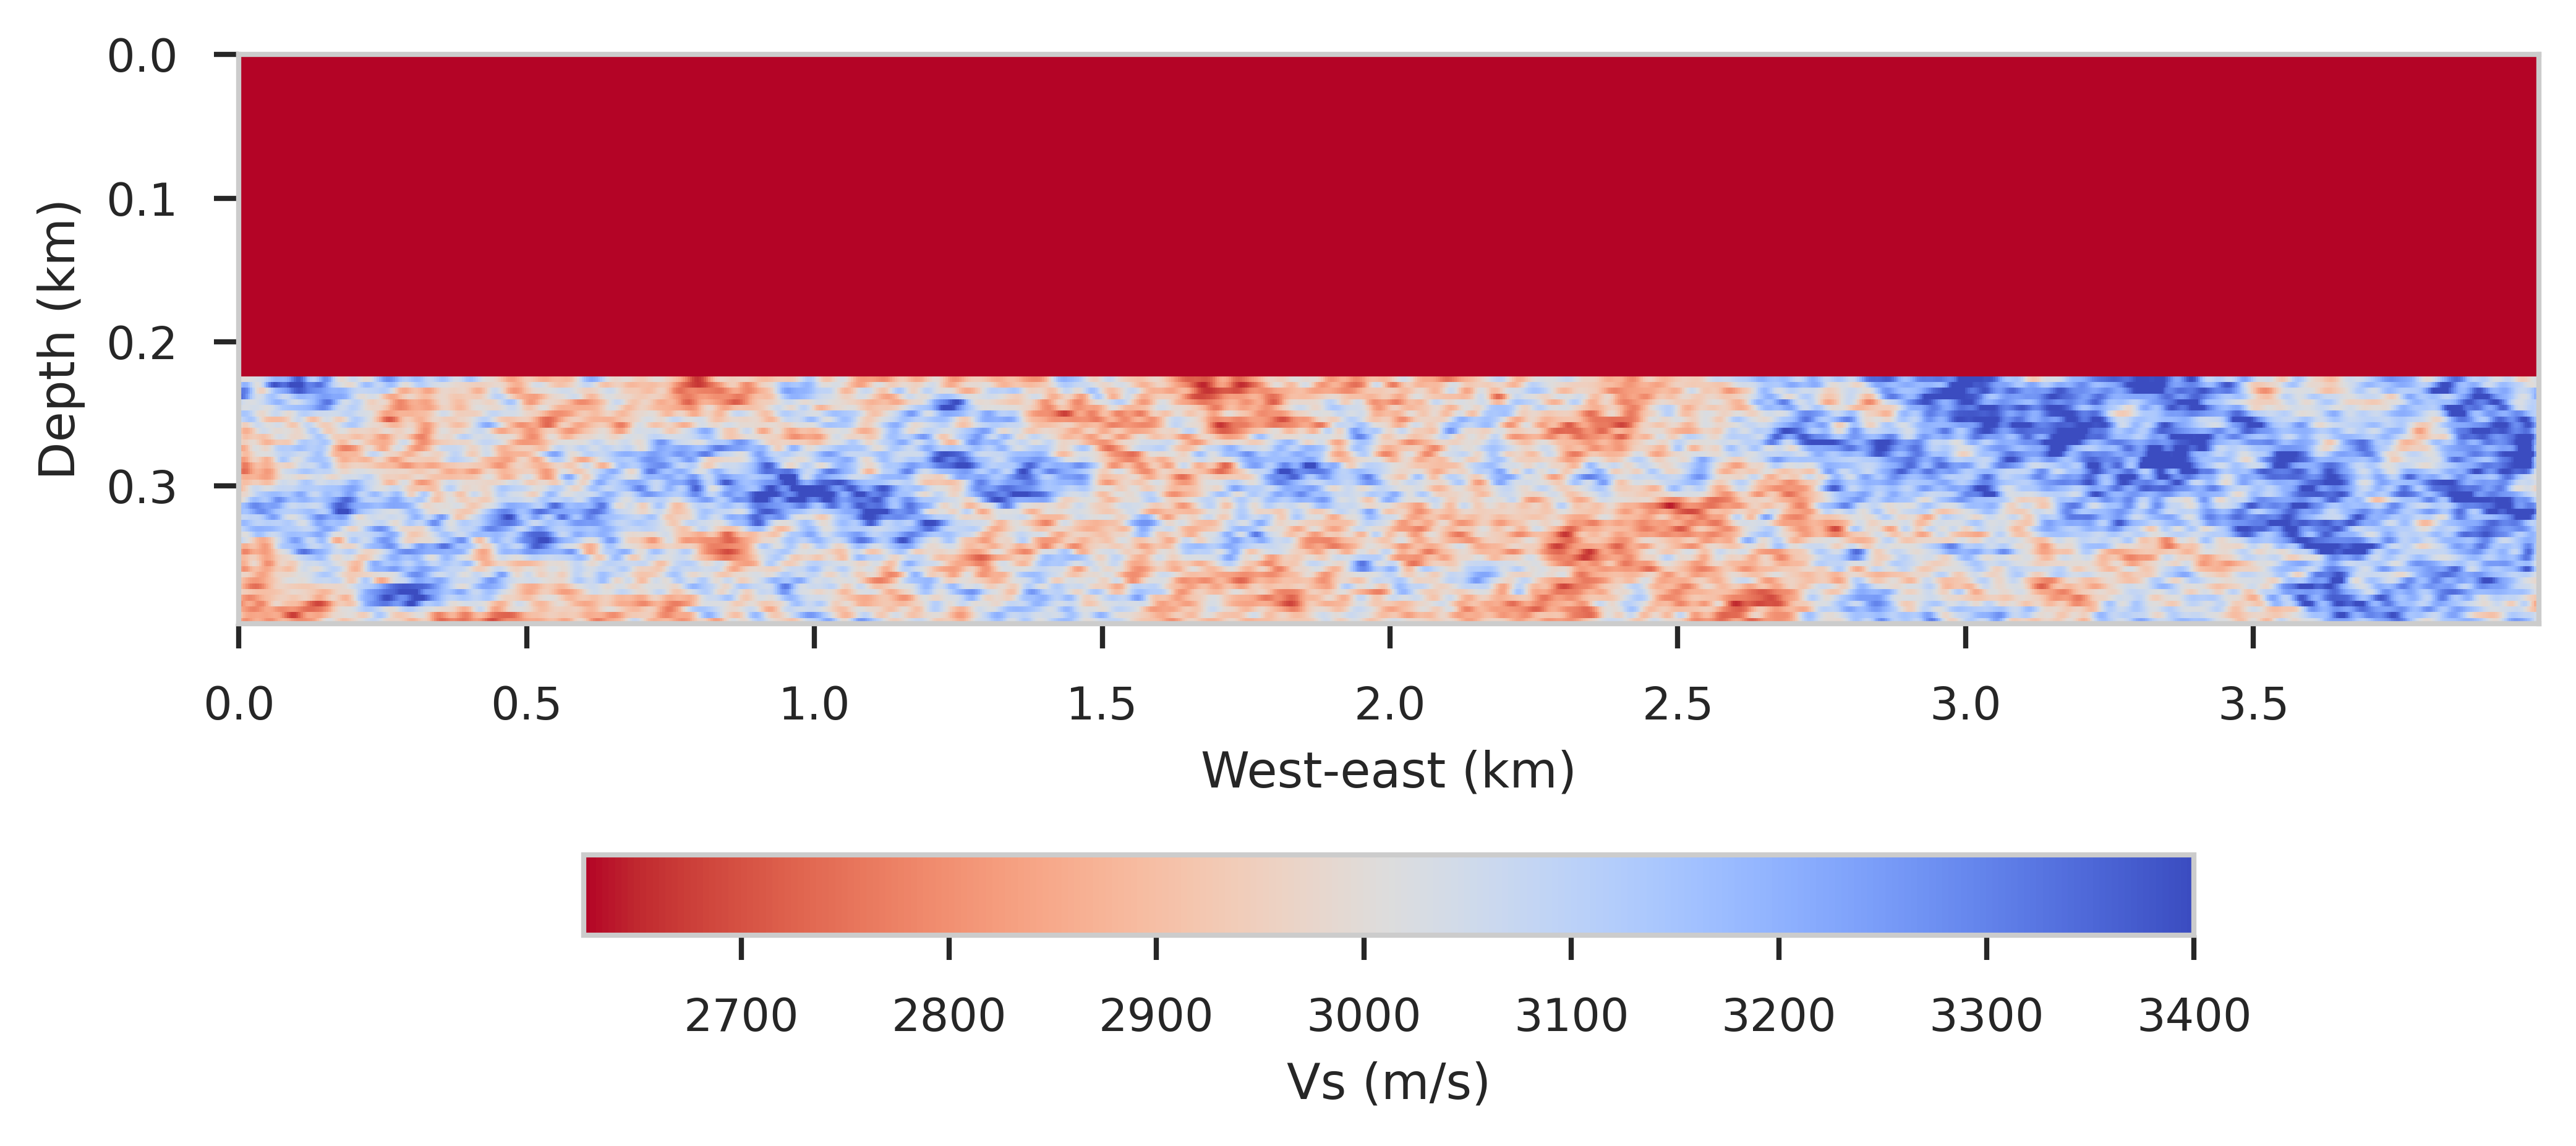

In [30]:
mesh = np.fromfile('/ccs/home/hzfmer/scratch/preevents/ssh_GVDA/mesh_gvda_4m_het.bin', dtype='float32')
mesh = mesh.reshape(100, 1000, 1000, 5)[:,:,:,1]
fig, ax = plt.subplots(dpi=600)
im = ax.pcolormesh(np.arange(0, 1000, 1) * 0.004, np.arange(100) * 0.004, mesh[:, 500, ::1],
               vmin=2624, cmap='coolwarm_r')
ax.set_aspect(2.5)
ax.invert_yaxis()
ax.set(xlabel='West-east (km)', ylabel='Depth (km)')
print(f'Minimum Vs including first layer: {np.min(mesh):.3f} m/s')
print(f'Minimum Vs excluding first layer: {np.min(mesh[1:, :,:]):.3f} m/s')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.7)
cbar.set_label('Vs (m/s)')
pass;

Minimum Vs including first layer: 818.699 m/s
Minimum Vs excluding first layer: 2624.382 m/s


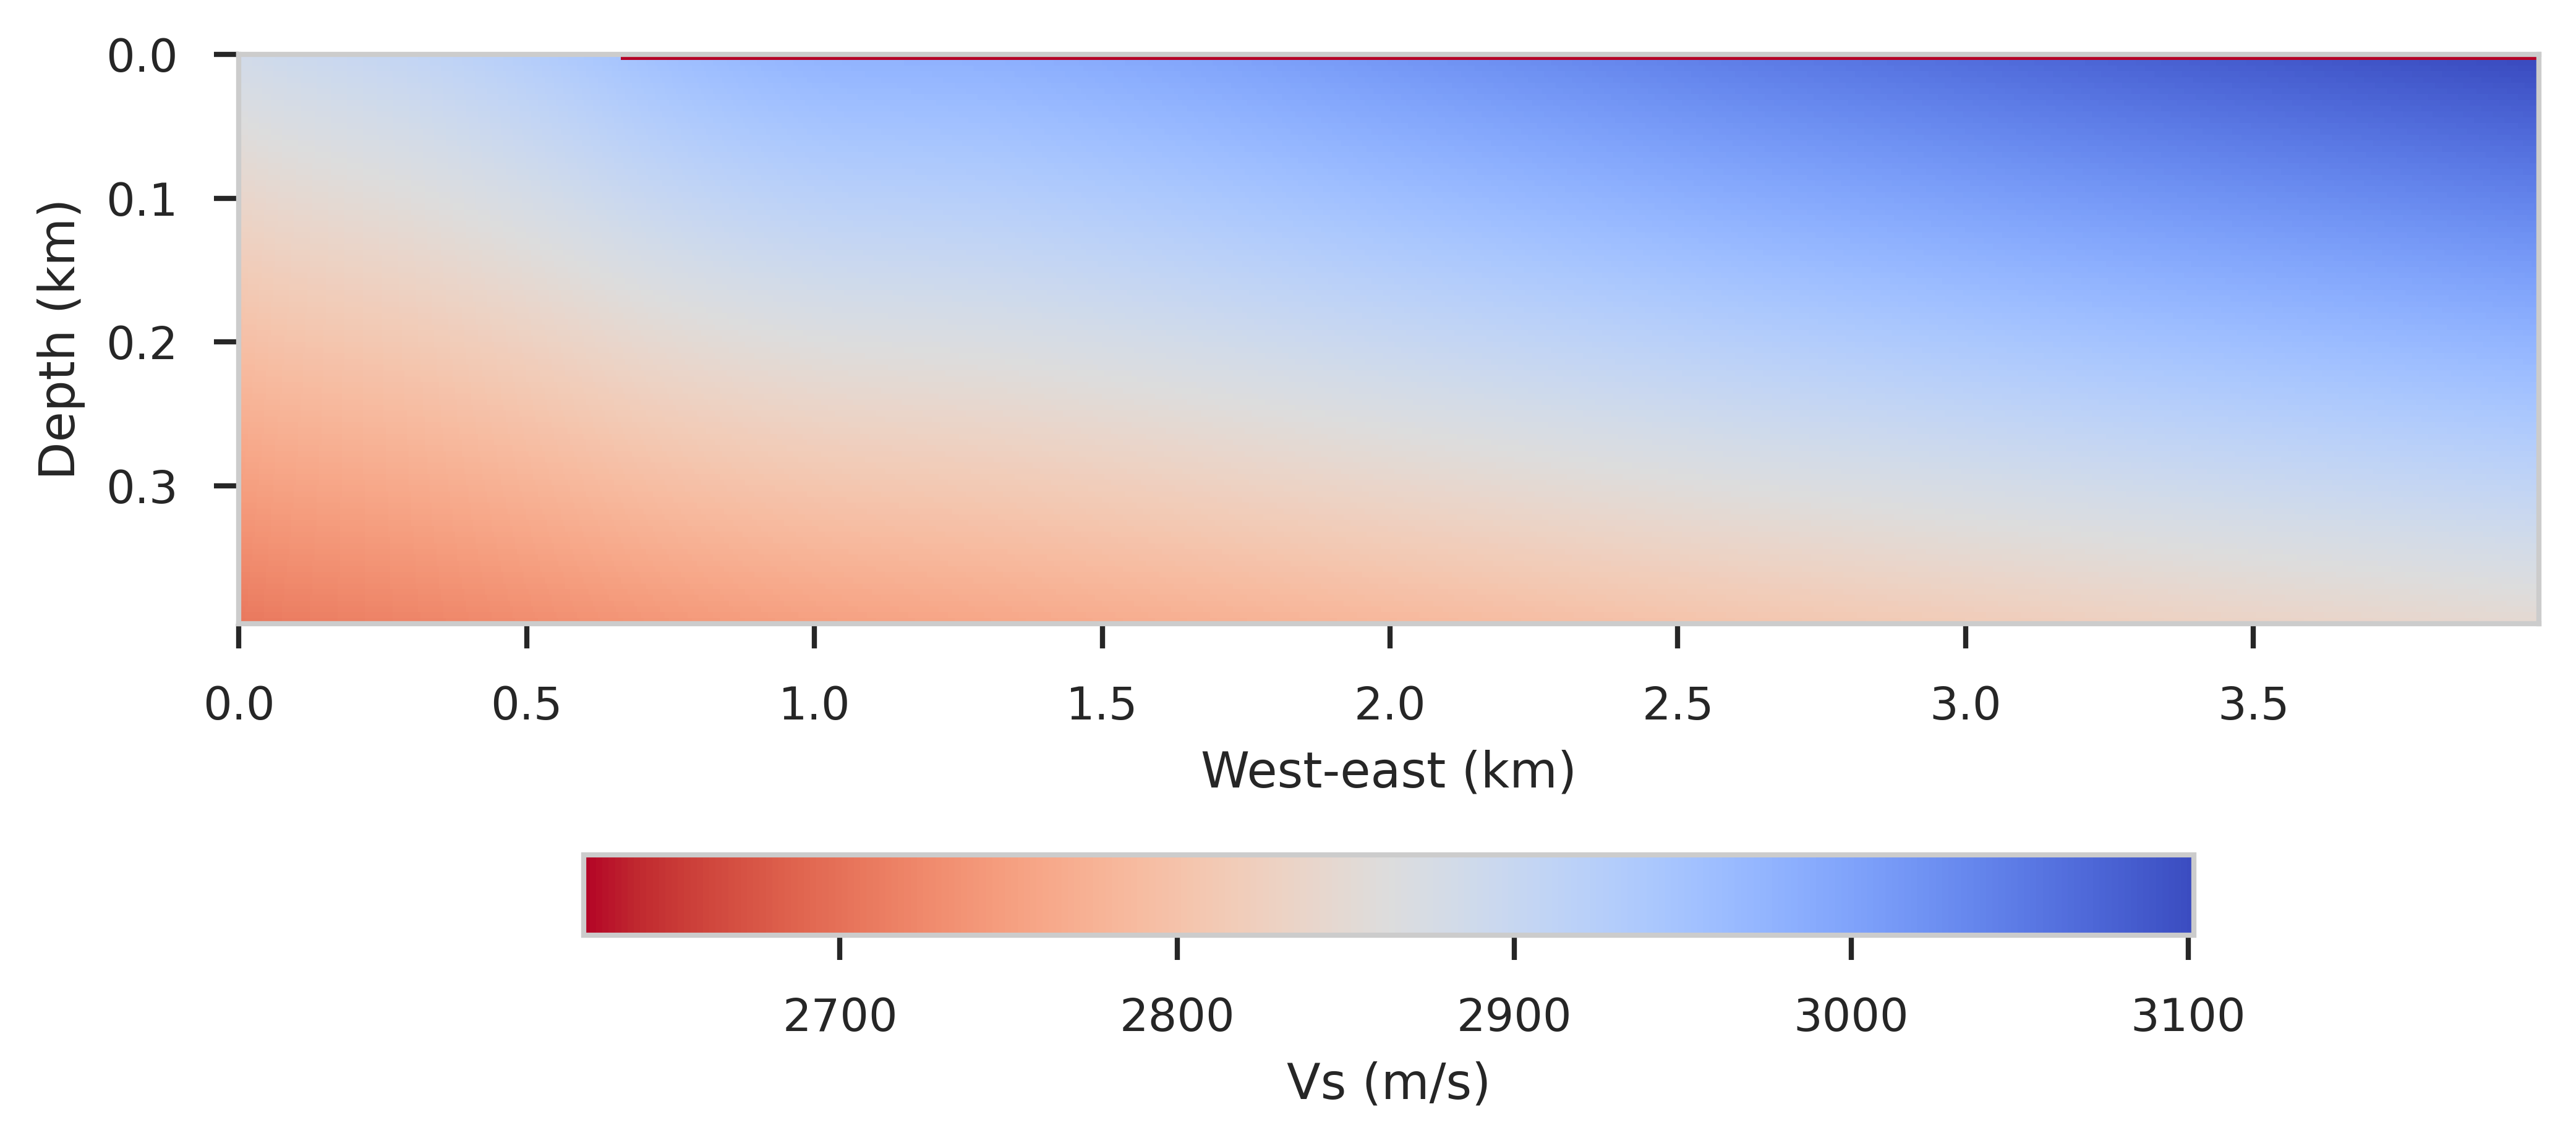

In [32]:
mesh = np.fromfile('/ccs/home/hzfmer/scratch/preevents/ssh_GVDA/gvda_cvmsi_4m.media', dtype='float32')
mesh = mesh.reshape(100, 1000, 1000, 3)[:,:,:,1]
fig, ax = plt.subplots(dpi=600)
im = ax.pcolormesh(np.arange(0, 1000, 1) * 0.004, np.arange(100) * 0.004, mesh[:, 500, ::1],
               vmin=2624, cmap='coolwarm_r')
ax.set_aspect(2.5)
ax.invert_yaxis()
ax.set(xlabel='West-east (km)', ylabel='Depth (km)')
print(f'Minimum Vs including first layer: {np.min(mesh):.3f} m/s')
print(f'Minimum Vs excluding first layer: {np.min(mesh[1:, :,:]):.3f} m/s')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.7)
cbar.set_label('Vs (m/s)')
pass;

In [ ]:
plt.figure(dpi=400)
plt.pcolormesh(np.arange(0, 1000, 20), np.arange(4), mesh[:4, 500, ::20],
              cmap='coolwarm')
plt.gca().invert_yaxis()
plt.gca().yaxis.set_ticks(np.arange(4))
plt.colorbar(orientation='horizontal')